# Name : Liyanage C.S.
# Index : 190353R

51
51


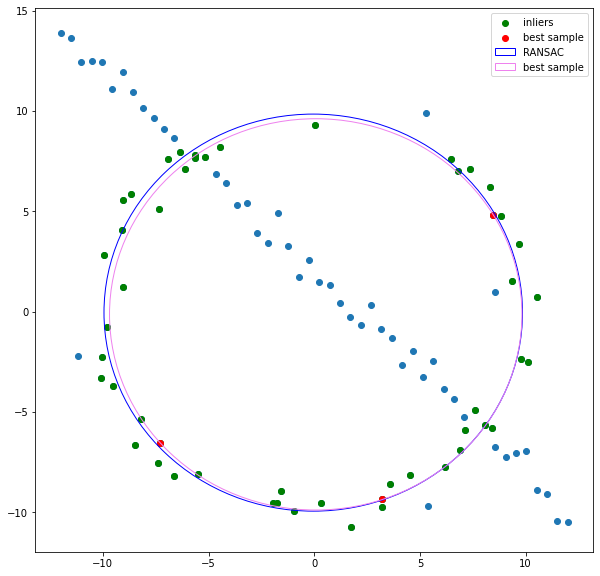

In [75]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
from circle_fit import least_squares_circle as lsc
# np . random . seed ( 0 )
N = 100
half_n = N // 2
r = 10
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n , 1)))
m, b = -1, 2
x = np.linspace(-12, 12 , half_n)
y = m * x + b + s*np.random.randn(half_n)
X_line = np.hstack((x . reshape(half_n , 1), y.reshape(half_n , 1)))
X = np.vstack((X_circ , X_line))

#drawing a circle using three points
def get_circle(x1 , y1 , x2 , y2 , x3 , y3):
    if (x1 - x2) == 0:
        if (x1 - x3) == 0:
            return 0

    if ((y1 - y2)/(x1 - x2)) == ((y1 - y3)/(x1 - x3)):
        return 0

    x1y1 = x1**2 + y1**2
    x2y2 = x2**2 + y2**2
    x3y3 = x3**2 + y3**2

    M11 = x1*(y2 - y3) - y1*(x2 - x3) + x2*y3 - x3*y2
    M12 = x1y1*(y2 - y3) - x2y2*(y1 - y3) + x3y3*(y1 - y2)
    M13 = x1y1*(x2 - x3) - x2y2*(x1 - x3) + x3y3*(x1 - x2)
    M14 = x1y1*(x2*y3 - x3*y2) - x2y2*(x1*y3 - x3*y1) + x3y3*(x1*y2 - x2*y1)

    x0 = M12 / (2 * M11)
    y0 = -M13 / (2 * M11)
    r = np.sqrt(x0**2 + y0**2 + M14 / M11)
    return [x0 , y0 , r]

def RANSAC_circle(X , threshold):
    N = len(X)
    max_iterations = int(np.log(1-0.95)/np.log(1-(1-0.5)**2))+1
    iterations = 0
    max_inliners = []

    while max_iterations > iterations:
        iterations += 1
        a, b, c = [np.random.randint(0,N) for i in range(3)]
        circle = get_circle(X[a][0] , X[a][1] , X[b][0] , X[b][1] , X[c][0] , X[c][1])
        inliners = []
        if circle == 0:
            iterations += 1
            continue
        for x in X:
            error = np.absolute(np.sqrt((x[0]-circle[0])**2 + (x[1] - circle[1])**2) - circle[2])
            if error < threshold:
                inliners.append(list(x))
        
        if len(max_inliners) < len(inliners):
            max_inliners = inliners.copy()
            best_sample = [[X[a][0] , X[a][1]] , [X[b][0] , X[b][1]] , [X[c][0] , X[c][1]]]
    
    xc,yc,radius,_ = lsc(max_inliners)
    return [xc,yc, radius] , np.array(max_inliners) , np.array(best_sample)


circle , inliners , best_sample = RANSAC_circle(X , 1)
print(len(inliners))
print(len(inliners[: , 0]))

fig , ax = plt.subplots(figsize = (10 , 10))
ax.scatter(X[: , 0] , X[:,1])
ax.scatter(inliners[:,0] , inliners[:,1] , color = 'green' , label = 'inliers')
ax.scatter(best_sample[:,0] , best_sample[:,1] , color = 'red' , label = 'best sample')
ransac = plt.Circle((circle[0] , circle[1]) , circle[2] , fill = False , color = 'blue' , label = 'RANSAC')
ax.add_artist(ransac)
best_circle = get_circle(best_sample[0][0] , best_sample[0][1] , best_sample[1][0] , best_sample[1][1] , best_sample[2][0] , best_sample[2][1])
best = plt.Circle((best_circle[0] , best_circle[1]) , best_circle[2] , fill = False , color = 'violet' , label = 'best sample')
ax.add_artist(best)
ax.legend()


(-0.5, 799.5, 502.5, -0.5)

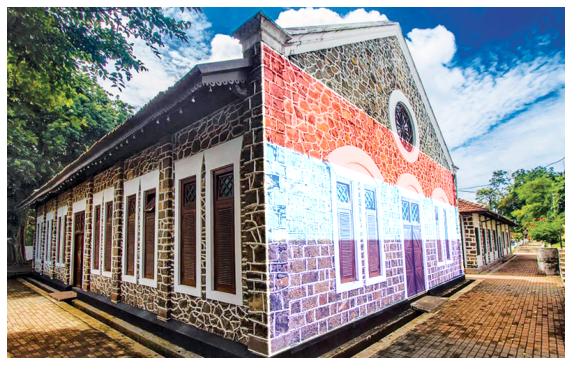

In [94]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt


def click(event , x , y ,flags , parameters):
    global points2 , img2
    if event == cv.EVENT_LBUTTONDOWN:
        points2.append([x,y])


img1 = cv.imread(r'./images/flag.jpg')
assert img1 is not None
img2 = cv.imread(r'./images/main hall.jpg')
assert img2 is not None

size = img1.shape[:2]
points1 = np.array([[0,0], [size[1]-1,0], [size[1]-1,size[0]-1], [0,size[0]-1]] , dtype = np.float32)
points2 = []

cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
cv.imshow('Image' , img2)
cv.setMouseCallback('Image' , click)
cv.waitKey(0)
cv.destroyAllWindows()

points2 = np.array(points2 , dtype = np.float32)

H , mask = cv.findHomography(points1 ,np.float32(points2))
img_p = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
img_blended = cv.addWeighted(img2, 1, img_p, 1, 1)


cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
cv.imshow('Image' , img_blended)
cv.waitKey(0)
cv.destroyAllWindows()

fig , ax = plt.subplots(figsize=(10,10))
ax.imshow(cv.cvtColor(img_blended , cv.COLOR_BGR2RGB))
ax.axis('off')



